In [103]:
# =========================
# Loan Approval Prediction
# Clean Refactored Pipeline
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib


In [104]:
# =====================
# 1. Load Data
# =====================
df = pd.read_csv(r"C:\Users\DELL\OneDrive - Sindh Madressatul Islam University\Desktop\MACHINELEARNING\loanapproval\data\loan_data.csv")

# =====================
# 2. Quick Checks
# =====================
print("Missing values:\n", df.isnull().sum())
print("Data types:\n", df.dtypes)

# Handle zero/negative income condition
if (df['person_income'] <= 0).any():
    raise ValueError("Dataset contains applicants with zero or negative income.")


Missing values:
 person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64
Data types:
 person_age                        float64
person_gender                      object
person_education                   object
person_income                     float64
person_emp_exp                      int64
person_home_ownership              object
loan_amnt                         float64
loan_intent                        object
loan_int_rate                     float64
loan_percent_income               float64
cb_person_cred_hist_length       

In [105]:
# =====================
# 3. Feature Engineering
# =====================
df['income_to_loan_ratio'] = df['person_income'] / df['loan_amnt']
df['debt_burden'] = df['loan_percent_income'] * df['loan_int_rate']

# Drop highly correlated variables
df = df.drop(['person_emp_exp', 'cb_person_cred_hist_length'], axis=1)


In [106]:
# 4. Features & Target
# =====================
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [107]:
# =====================
# 5. Preprocessing Setup
# =====================
numeric_features = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate',
                    'loan_percent_income', 'income_to_loan_ratio', 'debt_burden']
categorical_features = ['loan_intent', 'person_home_ownership']
ordinal_features = ['person_education']
binary_features = ['person_gender', 'previous_loan_defaults_on_file']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),

        ('edu', OrdinalEncoder(
            categories=[['High School','Associate','Bachelor','Master','Doctorate']],
            handle_unknown='use_encoded_value', unknown_value=-1
        ), ordinal_features),

        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'),
         categorical_features),

        ('bin', OrdinalEncoder(
            categories=[['M','F'], ['Y','N']],
            handle_unknown='use_encoded_value', unknown_value=-1
        ), binary_features)
    ]
)


In [108]:
# =====================
# 6. Evaluation Function
# =====================
def eval_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = None
    if hasattr(model, "predict_proba"):
        try:
            y_proba = model.predict_proba(X_test)[:, 1]
        except Exception:
            y_proba = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"\n=== {name} ===")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1-score:", f1)
    if roc is not None:
        print("ROC AUC:", roc)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

    if roc is not None:
        RocCurveDisplay.from_estimator(model, X_test, y_test)
        plt.title(f"ROC Curve - {name}")
        plt.show()

    return {"model": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": roc}



=== Logistic Regression (balanced) ===
Accuracy: 0.7777777777777778
Precision: 0.5
Recall: 0.7975
F1-score: 0.6146435452793835
ROC AUC: 0.8636432857142857
Confusion Matrix:
 [[5405 1595]
 [ 405 1595]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.77      0.84      7000
           1       0.50      0.80      0.61      2000

    accuracy                           0.78      9000
   macro avg       0.72      0.78      0.73      9000
weighted avg       0.83      0.78      0.79      9000



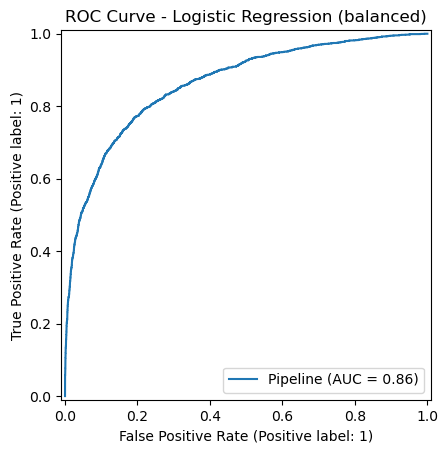


=== Logistic Regression + SMOTE ===
Accuracy: 0.7792222222222223
Precision: 0.5020576131687243
Recall: 0.793
F1-score: 0.6148478387284357
ROC AUC: 0.8636190714285714
Confusion Matrix:
 [[5427 1573]
 [ 414 1586]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.78      0.85      7000
           1       0.50      0.79      0.61      2000

    accuracy                           0.78      9000
   macro avg       0.72      0.78      0.73      9000
weighted avg       0.83      0.78      0.79      9000



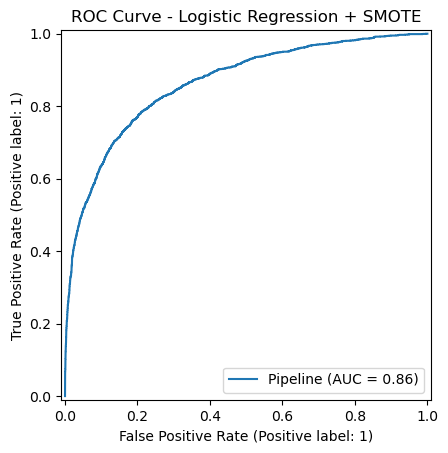

In [109]:
# Logistic Regression with class_weight balanced
pipe_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])
pipe_lr.fit(X_train, y_train)
res_lr = eval_model("Logistic Regression (balanced)", pipe_lr, X_test, y_test)

# Logistic Regression + SMOTE
pipe_smote_lr = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])
pipe_smote_lr.fit(X_train, y_train)
res_smote_lr = eval_model("Logistic Regression + SMOTE", pipe_smote_lr, X_test, y_test)



=== Decision Tree (balanced) ===
Accuracy: 0.8722222222222222
Precision: 0.7110228401191658
Recall: 0.716
F1-score: 0.71350274040857
ROC AUC: 0.8164285714285714
Confusion Matrix:
 [[6418  582]
 [ 568 1432]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      7000
           1       0.71      0.72      0.71      2000

    accuracy                           0.87      9000
   macro avg       0.81      0.82      0.82      9000
weighted avg       0.87      0.87      0.87      9000



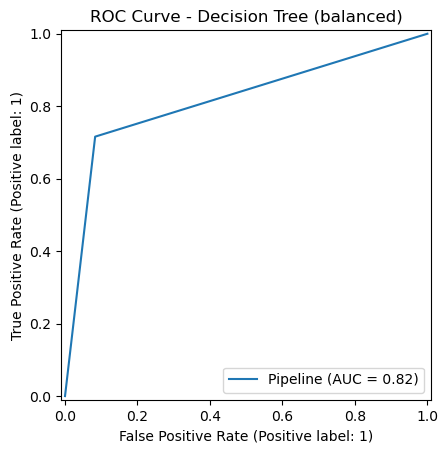


=== Decision Tree + SMOTE ===
Accuracy: 0.8402222222222222
Precision: 0.6156378600823045
Recall: 0.748
F1-score: 0.6753950338600452
ROC AUC: 0.8072857142857143
Confusion Matrix:
 [[6066  934]
 [ 504 1496]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89      7000
           1       0.62      0.75      0.68      2000

    accuracy                           0.84      9000
   macro avg       0.77      0.81      0.78      9000
weighted avg       0.85      0.84      0.85      9000



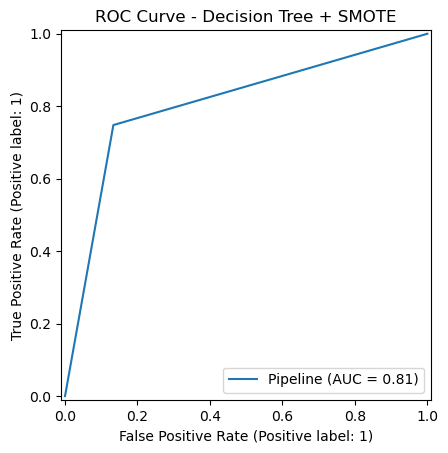

In [110]:
# Decision Tree (balanced)
pipe_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])
pipe_dt.fit(X_train, y_train)
res_dt = eval_model("Decision Tree (balanced)", pipe_dt, X_test, y_test)

# Decision Tree + SMOTE
pipe_smote_dt = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', DecisionTreeClassifier(random_state=42))
])
pipe_smote_dt.fit(X_train, y_train)
res_smote_dt = eval_model("Decision Tree + SMOTE", pipe_smote_dt, X_test, y_test)


In [111]:
# =====================
# 8. Save Final Model
# =====================
joblib.dump(pipe_smote_lr, "loan_approval_pipeline.joblib")
print("✅ Best model saved: loan_approval_pipeline.joblib")

✅ Best model saved: loan_approval_pipeline.joblib


In [102]:
# =====================
# 8. Save Final Model
# =====================
joblib.dump(pipe_smote_lr, "loan_approval_pipeline.joblib")  # .joblib format
joblib.dump(pipe_smote_lr, "loan_approval_pipeline.pkl")     # .pkl format
print("✅ Best model saved as loan_approval_pipeline.joblib and loan_approval_pipeline.pkl")


✅ Best model saved as loan_approval_pipeline.joblib and loan_approval_pipeline.pkl


In [114]:
df.columns

Index(['person_age', 'person_gender', 'person_education', 'person_income',
       'person_home_ownership', 'loan_amnt', 'loan_intent', 'loan_int_rate',
       'loan_percent_income', 'credit_score', 'previous_loan_defaults_on_file',
       'loan_status', 'income_to_loan_ratio', 'debt_burden'],
      dtype='object')

In [115]:
import sklearn
print(sklearn.__version__)

1.6.1
